# Notebook 
### Contribution Statement:

We, Frida(s206182), Cecilie(s214605), and Marie(s204052), collaborated and contributed equally to the project at hand.

Website: 

In [1]:
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import pickle
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import networkx.algorithms.community as nx_community
import re
import string
import networkx.algorithms.community as nx_comm
import netwulf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from collections import Counter

# Semantics analysis
%pip install textblob
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from PIL import Image



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


## Table of contents

1. [Datachoice](#data-choice)
    * [What data did we choose?](#what-data)  
    * [Why is this data interesting?](#motivation) 
<br>
<br>

2. [Data collection and filtering](#data-processing)
    * [Collecting data with Harry Potter API](#API)
    * [Webscraping wikis](#webscraping)
    * [Initial filtering of the data](#initial-filtering)
        * [Removing inanimate and unidentified data](#remove-inanimate)
        * [Cleaning species attribute](#clean-spicies)
        * [Removing actor names](#remove-actor)
<br>
<br>

3. [Making the network](#make-network)
    * [Initializing graph and edgelist](#init-graph)
        * [Adding weighted edges to graph](#weighted_edges)
        * [Removing nodes with degree zero](#rem_degree_0)
        * [Investigating communities](#init_communities)
    * [Making random network](#make-random-network)
        * [Visualizing random graph](#visualizing_random_graph)
    * [Visualizations](#visualizations)
<br>
<br>
4. [Statistics](#statistics)
    * [Harry Potter network](#harry_statistics)
        * [Statistical measurements](#harry_mean_median_osv)
        * [Clustering coefficient](#harry_clustering_coef)
    * [Random network](#random_statistics)
        * [Statistical measurements](#random_mean_median_osv)
        * [Clustering coefficient](#random_clustering_coef)
        * [Assorsativity](#random_assorsativity)
        * [Shortest path](#random_shortest_path)
        * [Closeness centrality](#random_closeness_cent)

<br>
<br>
5. [Semantic analysis](#semantic-analysis)
    * [insert the name](insert the link)
    * [insert the name](insert the link)
        * [insert the name](insert the link)


# 1. Data choice <a id='data-choice'></a>

<a id='what-data'></a>
### What data did we choose? 



<a id='motivation'></a>
### Why is this data interesting 

<a id='data-processing'></a>
# 2. Data collection and filtering

<a id='unique-id'></a>
## Collecting data with Harry Potter API

In [ ]:
# API link
BASE_URL = "https://api.potterdb.com/"
VERSION = "v1/"
RESOURCE = "characters"

my_url = BASE_URL + VERSION + RESOURCE
print(my_url)
all_data = {}
counter = 0
for i in range(50):

    url = my_url + f"?page[number={i+1}]&page[size=100]"
    r = requests.get(url)
    data = r.json()["data"]

    for i in data:
        all_data[counter] = {}
        name = (i['attributes']['name'])
        all_data[counter]['Name'] = i['attributes']['name']
        all_data[counter]['Blood status'] = i['attributes']['blood_status']
        all_data[counter]['House'] = i['attributes']['house']
        all_data[counter]['Species'] = i['attributes']['species']
        all_data[counter]['Death time'] = i['attributes']['died']
        all_data[counter]['Alias'] = i['attributes']['alias_names']
        all_data[counter]['Wiki'] = i['attributes']['wiki']
        all_data[counter]['Gender'] = i['attributes']['gender']
        counter +=1
    
df_data = pd.DataFrame.from_dict(all_data, orient='index')

<a id='webscraping'></a>
## Webscrape text data and node links from wiki

In [114]:
# Function to webscrape Harry Potter wiki for text and links
def webscrapeWiki(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    content_div = soup.find('div', {'id': 'mw-content-text'})
    text = ""
    exclude_sections = ["Appearances"]
    exclude_links = ["Appearances"]

    for p in content_div.find_all('p'):
        section_heading = p.find_previous_sibling('h2')
        if section_heading and section_heading.find('span', {'class': 'mw-headline'}).text in exclude_sections:
            break
        elif p.find_parents('table'):
            continue
        text += p.get_text() + " "

    links = []
    for ul in content_div.find_all("ul"):
        section_heading = ul.find_previous_sibling('h2')
        if section_heading and section_heading.find('span', {'class': 'mw-headline'}).text in exclude_sections:
            break
        elif ul.find_parents('table'):
            continue
        for li in ul.find_all("li"):
            for a in li.find_all("a"):
                if a.find_parents('table'):
                    continue
                split = a['href'].split("/")
                if len(split)>1:
                    if split[1]=="wiki" and section_heading is not None and section_heading.find('span', {'class': 'mw-headline'}).text not in exclude_links:
                        links.append(split[2])
    
    infobox = soup.find('aside', {'class': 'portable-infobox'})
    if infobox:
        for a in infobox.find_all('a'):
            href = a.get('href')
            if href:
                split = href.split("/")
                if len(split)>1:
                    if split[1]=="wiki":
                        links.append(split[2])

    return text, links

df_data["Wiki text"], df_data["Character links"] = zip(*df_data["Wiki"].apply(webscrapeWiki))

In [209]:
df_data.head(2)

name Blood status House  \
0  1992 Gryffindor vs Slytherin Quidditch match s...         None  None   
1  1996 Gryffindor Quidditch Keeper trials specta...         None  None   

  Species Death time Alias                                               Wiki  \
0    None       None  None  https://harrypotter.fandom.com/wiki/1992_Gryff...   
1    None       None  None  https://harrypotter.fandom.com/wiki/1996_Gryff...   

  Gender                                          Wiki text  \
0   None  The title of this article is conjectural.  Alt...   
1   None  In September 1996, a number of unidentified sp...   

                                     Character links  \
0  [Canon, Filius_Flitwick, Irma_Pince, Severus_S...   
1  [Harry_Potter_and_the_Half-Blood_Prince, Septe...   

                                           Wiki name  \
0  1992_Gryffindor_vs_Slytherin_Quidditch_match_s...   
1  1996_Gryffindor_Quidditch_Keeper_trials_specta...   

                                 Sum character links  
0  {'Filius_Flitwick': 2, 'Irma_Pince': 3, 'Sever...  
1  {'Harry_Potter': 1, 'Ronald_Weasley': 1, 'Corm...

In [120]:
def wikiName(wikiURL):
    return wikiURL.split("/")[-1]

def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks

df_data["Wiki name"] = df_data["Wiki"].apply(wikiName)
df_data["Sum character links"] = df_data["Character links"].apply(Counter)
df_data["Sum character links"] = df_data["Sum character links"].apply(checkLinks,wikiNames=df_data["Wiki name"])

#Save dataframe
df_data.to_pickle("df_data_updated2")

<a id='initial-filtering'></a>
## Initial filtering of data

In [2]:
# Load dataframe:
df_data_loaded = pd.read_pickle("df_data_updated2")

<a id='remove-inanimate'></a>
### Removing unidentified data points and inanimate links

In [3]:
# Getting filtered data
# Removing names holding 'Unidentified'
def checkUnidentified(wikiName):
    check = "Unidentified"
    if len(wikiName)>len(check):
        if wikiName[:len(check)]==check:
            return True
    return False

# Checking if links are persons
def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks


def removeDegreeZeros(df):
    hasDegreeDict = {}
    # Check if each character has out-degree:
    for i in df.index:
        hasDegreeDict[df["Wiki name"][i]] = False
        if len(df["Sum character links"][i]):
            hasDegreeDict[df["Wiki name"][i]] = True
    
    # Look at all character in-degree references:
    for i in df.index:
        for n in df["Sum character links"][i]:
            hasDegreeDict[n] = True
    
    remove = [name for (name, degrStatus) in hasDegreeDict.items() if not degrStatus]
    df_degree = df.drop(df[df["Wiki name"].isin(remove)].index)
    return df_degree

len_data = len(df_data_loaded)

# Filter data after having some information of Blood status, house, species, death time or alias
filtered_data = df_data_loaded[~((df_data_loaded["Blood status"].isnull())&(df_data_loaded["House"].isnull())&(df_data_loaded["Species"].isnull())&(df_data_loaded["Death time"].isnull())&(df_data_loaded["Alias"].isnull()))]
filt_data1 = len(filtered_data)

# Filter unidentified people away
filtered_data = filtered_data[~filtered_data["Wiki name"].apply(checkUnidentified)]
filt_data2 = len(filtered_data)

# Filter based on species (removing groups)
filtered_data = filtered_data[~(filtered_data['Species']=='Humans')]
filt_data3 = len(filtered_data)

# Remove links to non-characters:
filtered_data["Sum character links"] = filtered_data["Sum character links"].apply(checkLinks,wikiNames=filtered_data["Wiki name"])
filt_data4 = len(filtered_data)

# Remove characters with no links out or in:
filtered_data = removeDegreeZeros(filtered_data)
filt_data5 = len(filtered_data)

print('First filter removes:', len_data-filt_data1, 'characters')
print('Second filter removes:', len_data-filt_data2, 'characters')
print('Fourth filter removes:', len_data-filt_data3, 'characters')
print('Fifth filter removes:', len_data-filt_data5, 'characters')


First filter removes: 91 characters
Second filter removes: 522 characters
Fourth filter removes: 578 characters
Fifth filter removes: 2310 characters


In [4]:
# Function for cleaning the house names (removing unnecessary information)
def cleanHouses(House):
    if House != None:
        strings = House.split(' ')
        if len(strings) == 1:
            return strings[0]
        if len(strings) != 1:
            if len(strings) > 2:
                return 'Unknown'
            if strings[-1][-1] == ')':
                return strings[0]
    if House == None:
        return 'Unknown'

# Applying filter
filtered_data['House'] = filtered_data['House'].apply(cleanHouses)

<a id='remove-actor'></a>
### Removing actor names


In [5]:
# Function that scrapes actor names from each HP movies wikipediapage and appends them to a list
def scrape_actors(url, actor_names):
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
        soup = BeautifulSoup(html_content, 'html.parser')
        cast_element = soup.find('table', class_='cast_list')
        if cast_element:
            for row in cast_element.find_all('tr'):
                actor_element = row.find('td', class_='primary_photo')
                if actor_element:
                    actor_name = actor_element.find('img').get('alt')
                    if actor_name not in actor_names:
                        actor_names.append(actor_name)
    return actor_names

actor_names = []

# The Philosopher's Stone
url = 'https://www.imdb.com/title/tt0241527/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Chamber of Secrets
url = 'https://www.imdb.com/title/tt0295297/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Prisoner of Azkaban
url = 'https://www.imdb.com/title/tt0304141/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Goblet of Fire
url = 'https://www.imdb.com/title/tt0330373/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Order of the Phoenix
url = 'https://www.imdb.com/title/tt0373889/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# Half-Blood Prince 
url = 'https://www.imdb.com/title/tt0417741/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Deathly Hallows – Part 1
url = 'https://www.imdb.com/title/tt0926084/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)
# The Deathly Hallows – Part 2
url = 'https://www.imdb.com/title/tt1201607/fullcredits#cast'
actor_names = scrape_actors(url, actor_names)

# Cleaning 'name' column for actornames
mask = ~filtered_data['Name'].isin(actor_names)
filtered_data = filtered_data[mask]
filt3_data = len(filtered_data)

print('Third filter removes:', len_data-filt3_data, 'characters')

Third filter removes: 2313 characters


In [6]:
filtered_data.head(5)

Name Blood status    House Species Death time Alias  \
9   Aberforth Dumbledore   Half-blood  Unknown   Human       None  [Ab]   
10             Abernathy         None  Unknown   Human       None  None   
13     Abigail R. Cankus         None  Unknown   Human       None  None   
15         Able Spudmore         None  Unknown   Human       None  None   
16               Abraham         None  Unknown   Human       None  None   

                                                 Wiki  Gender  \
9   https://harrypotter.fandom.com/wiki/Aberforth_...    Male   
10      https://harrypotter.fandom.com/wiki/Abernathy    Male   
13  https://harrypotter.fandom.com/wiki/Abigail_R....  Female   
15  https://harrypotter.fandom.com/wiki/Able_Spudmore    Male   
16        https://harrypotter.fandom.com/wiki/Abraham    Male   

                                            Wiki text  \
9   \n\n\n\n\n\n\n\nAberforth Dumbledore\n\n\nBiog...   
10  \n\n\n\n\n\n\n\nAbernathy\n\n\nBiographical in...   
13  \n\nAbigail R. Cankus\n\n\nBiographical inform...   
15  \n\nAble Spudmore\n\n\nBiographical informatio...   
16  "Point me!"\n \n\n\n\n\n\n\n\nAbraham\n\n\nPhy...   

                                      Character links             Wiki name  \
9   [Charm, Aberforth_Dumbledore%27s_goat_charm, P...  Aberforth_Dumbledore   
10  [Apparition, Lestrange_Mausoleum, Abernathy%27...             Abernathy   
13  [United_States_of_America, Human, Template:Ind...     Abigail_R._Cankus   
15  [1923, Human, Randolph_Spudmore, Spudmore_fami...         Able_Spudmore   
16  [Harry_Potter_and_the_Philosopher%27s_Stone_(f...               Abraham   

                                  Sum character links  
9   {'Albus_Dumbledore': 2, 'Gellert_Grindelwald':...  
10  {'Percival_Graves': 1, 'Peter_Pettigrew': 1, '...  
13                                                 {}  
15                           {'Randolph_Spudmore': 1}  
16                {'Albus_Dumbledore': 1, 'Isaac': 1}

<a id='make-network'></a>
# 3. Making the network

### Initializing graph and edgelist
 <a id='init-graph'></a>

In [9]:
# making edgelist
wiki_names = list(filtered_data['Wiki name'])
character_links = filtered_data['Sum character links']
houses = list(filtered_data['House'])

# Initializing graph
G = nx.MultiDiGraph()
# Adding group according to house attribute
for i in range(len(wiki_names)):
        G.add_node(wiki_names[i], group = houses[i])
print(G)

MultiDiGraph with 1751 nodes and 0 edges


In [10]:
# Making weighted edgelist
edges = []
for j in filtered_data.index:
    name = filtered_data['Wiki name'][j]
    links = filtered_data['Sum character links'][j]
    for key, val in links.items():
        edges.append(((name, key, val)))

#### Adding weighted edges to graph
 <a id='weighted-edges'></a>

In [11]:
# Adding edgelist to graph
G.add_weighted_edges_from(edges)
print(G)

MultiDiGraph with 1752 nodes and 7875 edges


#### Removing nodes with degree zero
 <a id='rem_degree_0'></a>

In [12]:
# Remove nodes with no edges
remove = [node for node,degree in G.degree() if degree == 0]
G.remove_nodes_from(remove)
print(f"{len(remove)} nodes with degree 0 were removed.") # Should be 0 as they are already removed
print(G)

G.remove_node('Jamie_Wolpert_(in-universe)') # removing node, that is added when graph is made, but not in original dataset

0 nodes with degree 0 were removed.
MultiDiGraph with 1752 nodes and 7875 edges


#### Visualizing graph
 <a id='visualizing_graph'></a>

In [12]:
# Interactive visualization of graph (with group attribute according to 'house')
netwulf.interactive.visualize(G)

(None, None)

### Investigating communities
 <a id='init_communities'></a>

In [13]:
# Finding communities from splitting graph by 'House' attribute
import networkx.algorithms.community as nx_comm
houses = list(filtered_data['House'])
houses_types = []
for i in houses:
    if i not in houses_types:
        houses_types.append(i)
    
print('The different houses are:', houses_types)

houses_com = []
for i in houses_types:
    houses_com.append({x for x,y in G.nodes(data=True) if y['group']==i})

# computing modularity of 'house' split
house_mod = nx_comm.modularity(G, houses_com)
print('The modularity for the "house" split is: ' + str(house_mod))
no_comm = len(houses_com)
print('The number of "house" communities is ' + str(no_comm))
size_comm = []
for i in range(no_comm):
    size_comm.append(len(houses_com[i]))

The different houses are: ['Unknown', 'Hufflepuff', 'Slytherin', 'Ravenclaw', 'Gryffindor', 'Thunderbird', None, 'Pukwudgie', 'Wampus']
The modularity for the "house" split is: 0.1334328195533092
The number of "house" communities is 9


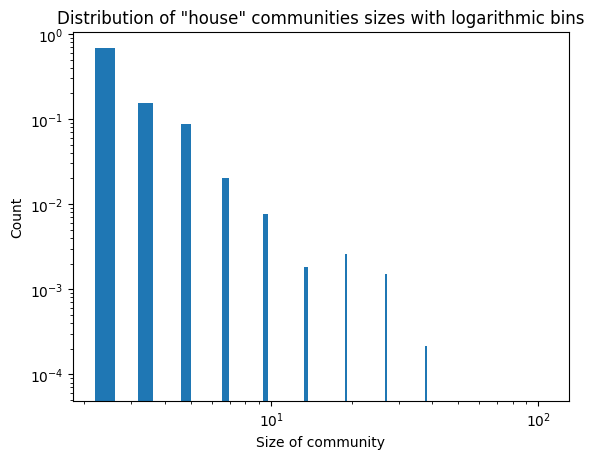

In [24]:
# Plotting distribution of sizes of 'house' communities
bins = np.logspace(0, np.log10(max(size_comm)), 15)
hist, edges = np.histogram(size_comm, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(xx, yy, width)
ax.set_title('Distribution of "house" communities sizes with logarithmic bins')
ax.set_xlabel('Size of community')
ax.set_ylabel('Count')
ax.set_yscale("log")
ax.set_xscale("log")

In [16]:
# Finding louvain communities
louv_comm = nx_comm.louvain_communities(G)

modularity_louv = nx_comm.modularity(G, louv_comm)
print('The modularity of Louvain algorithm is ' + str(modularity_louv))

no_comm = len(louv_comm)
print('The number of Louvain communities is ' + str(no_comm))

size_comm = []
for i in range(no_comm):
    size_comm.append(len(louv_comm[i]))

The modularity of Louvain algorithm is 0.5768047079355895
The number of Louvain communities is 361


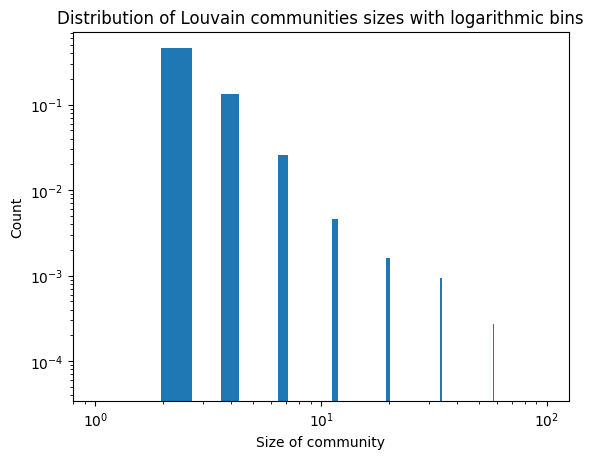

In [27]:
# Plotting distribution of comminuty sizes
bins = np.logspace(0, np.log10(max(size_comm)), 10)
hist, edges = np.histogram(size_comm, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_title('Distribution of Louvain communities sizes with logarithmic bins')
ax.set_xlabel('Size of community')
ax.set_ylabel('Count')
#ax.set_ylim(0,20)
ax.set_yscale("log")
ax.set_xscale("log")

## Making random network
 <a id='make-random-network'></a>

In [34]:
# Initliazing random graph with same number of nodes and edges as Harry Potter network
rand_G = nx.gnm_random_graph(len(G.nodes(data=True)), len(G.edges()), seed=42, directed=True)
print(rand_G)

DiGraph with 1751 nodes and 7874 edges


#### Visualizing random graph
 <a id='visualizing_random_graph'></a>

In [35]:
# Visualizing random graph
netwulf.interactive.visualize(rand_G)

(None, None)

## Visualizations
 <a id='visualizations'></a>

In [28]:
# Top 10 species
top_species = pd.DataFrame(filtered_data['Species'].value_counts().head(10))
top_species

Species
Human                       1518
Human (formerly), Ghost       13
Goblin                        10
House-elf                      9
Giant                          9
Cat                            8
Bowtruckle                     7
Centaur                        6
Owl                            6
Hippogriff                     5

In [29]:
print('Number of unknown houses: ', len(filtered_data[filtered_data['House']=='Unknown']))
# Removing unknown houses
filtered_data = filtered_data[~(filtered_data['House']=='Unknown')]
# Getting data ready for plotting in a histogram
houses = filtered_data['House']
houses_types = []
for i in houses:
    if i not in houses_types:
        houses_types.append(i)

dict = {}
for i in range(len(houses_types)):
    dict[i] = houses_types[i]

keys = list(dict.keys())
values = list(dict.values())

houses_int = []
for i in houses:
    for j in range(len(values)):
        if i == values[j]:
            houses_int.append(keys[j])

dict_len = []
for i in range(len(houses_types)):
    dict_len.append(len(filtered_data[filtered_data['House']==houses_types[i]]))

len_houses = pd.DataFrame()
len_houses['House'] = dict.values()
len_houses['Count'] = dict_len

Number of unknown houses:  1398


In [71]:
import plotly.express as px
# Plotting the distribution of house sizes
fig = px.bar(len_houses, x='House', y='Count', title="Count of members in each house", width=800, height=400)
fig.update_traces(width=0.8, marker_color=[('#ffc500'), ('#1a472a'), ('#0a5ea8'), ('#7f0909'), ('#8A8C8A'), ('#8A8C8A'),('#8A8C8A')], opacity=0.75)
fig.update_xaxes(griddash = 'solid')
fig.update_layout(title_x=0.5)
fig.show()

# Save figure as png
import os
if not os.path.exists("images"):
    os.mkdir("images")
fig.write_image("houses_count.png")

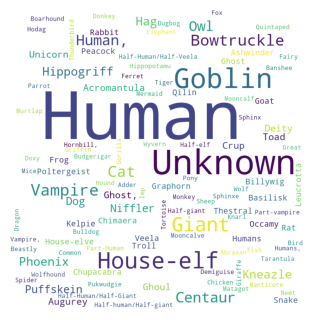

In [26]:
# Define a function to generate wordcloud
def generate_freq_wordcloud(data):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10)
    wordcloud.generate_from_frequencies(frequencies = data)
    plt.figure(figsize = (3,3), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

generate_freq_wordcloud(species_freq)

In [30]:
# Finding top 10 nodes (characters) with highest in-degree and out-degree
in_degrees = {}
for i in G.in_degree:
    new_name=i[0].replace('_', ' ')
    in_degrees[new_name] = i[1]

out_degrees = {}
for i in G.out_degree:
    new_name=i[0].replace('_', ' ')
    out_degrees[new_name] = i[1]

max_in_deg = sorted(in_degrees, key=in_degrees.get, reverse=True)[:10]
max_out_deg = sorted(out_degrees, key=out_degrees.get, reverse=True)[:10]

in_df = pd.DataFrame(sorted(in_degrees.values(), reverse=True)[:10],max_in_deg,columns=['In-degree'])
out_df = a = pd.DataFrame(sorted(out_degrees.values(), reverse=True)[:10],max_out_deg,columns=['Out-degree'])

In [77]:
in_df

In-degree
Harry Potter            210
Tom Riddle              187
Albus Dumbledore        111
Ronald Weasley           94
Hermione Granger         90
Sirius Black             67
Ginevra Weasley          65
Severus Snape            65
Arthur Weasley           62
Draco Malfoy             62

In [78]:
out_df

Out-degree
Harry Potter                 92
Albus Dumbledore             73
Jacob's sibling              62
Ronald Weasley               60
Hermione Granger             59
Arthur Weasley               49
Bellatrix Lestrange          48
Ginevra Weasley              48
Cedrella Black               45
Tom Riddle                   43

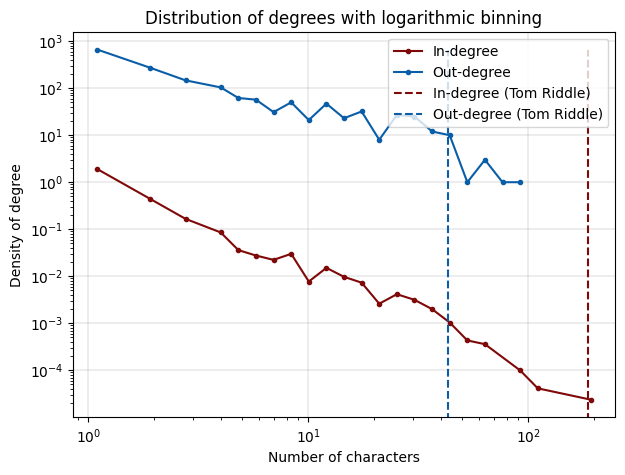

In [31]:
# Using matplotlib to plot the distribution of in-degrees and out-degrees
in_degrees = [degree for character, degree in G.in_degree()]
out_degrees = [degree for character, degree in G.out_degree()]

bins = np.logspace(0, np.log10(max(in_degrees)),30)
hist, edges = np.histogram(list(in_degrees), bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='In-degree', color=('#7f0909'))
hist, edges = np.histogram(list(out_degrees), bins = bins, density = False)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])
ax.plot(xx, yy, marker='.', label='Out-degree', color=('#0a5ea8'))

ax.set_xlabel('Number of characters')
ax.set_ylabel('Density of degree')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of degrees with logarithmic binning")
#ax.vlines(max(in_degrees),  0, max(yy), ls="--", colors='black', label='In-degree (Harry Potter)')
#ax.vlines(max(out_degrees),  0, max(yy), ls="--", colors='grey', label='Out-degree (Harry Potter)')
#ax.vlines(60,  0, max(yy), ls="--", colors='royalblue', label='In-degree (Ronald Weasley)')
#ax.vlines(28,  0, max(yy), ls="--", colors='lightblue', label='Out-degree (Ronald Weasley)')
ax.vlines(187,  0, max(yy), ls="--", colors=('#7f0909'), label='In-degree (Tom Riddle)')
ax.vlines(43,  0, max(yy), ls="--", colors=('#0a5ea8'), label='Out-degree (Tom Riddle)')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('degree_distribution_network.png', dpi=300)
plt.show()

/var/folders/dd/wg5fw_vd1274h5p9w923x5740000gn/T/ipykernel_36929/608444523.py:9: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.



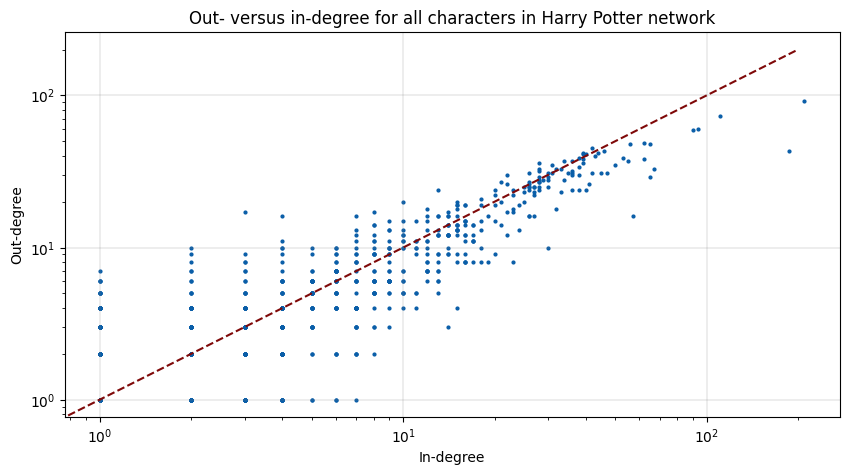

In [86]:
# Plotting in-degree vs out-degree (finding an relationship)
in_degrees = [degree for character, degree in G.in_degree()]
out_degrees = [degree for character, degree in G.out_degree()]

fig, ax = plt.subplots(figsize=(10,5) ,dpi=100)
ax.scatter(in_degrees, out_degrees, c=('#0a5ea8'), s=4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.plot([0, 10, 50, 100, 150, 175, 200], [0, 10, 50, 100, 150, 175, 200], "r--", color=('#7f0909'))
ax.set_xlabel('In-degree')
ax.set_ylabel('Out-degree')
ax.set_title('Out- versus in-degree for all characters in Harry Potter network')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('in_out_scatter.png', dpi=300)

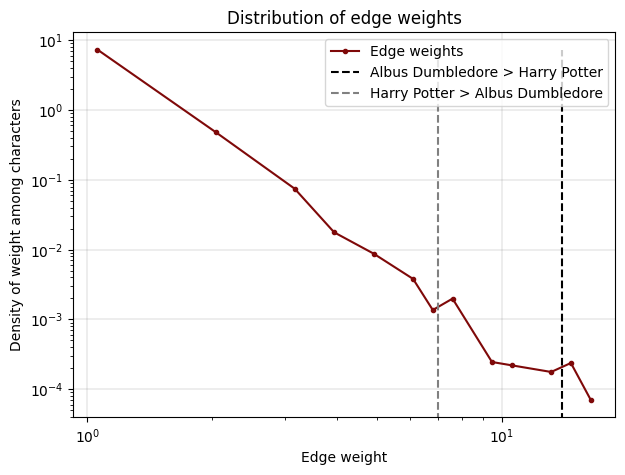

In [32]:
# Looking at the distribution of edge weights
all_weights = []
for i in list(G.edges(data=True)):
    w = list(i[2].values())
    all_weights.append(w[0])

bins = np.logspace(0, np.log10(max(all_weights)),30)
hist, edges = np.histogram(list(all_weights), bins = bins, density = True)
x = (edges[1:] + edges[:-1])/2

xx, yy = zip(*[(i, j) for (i,j) in zip(x, hist) if j>0])

fig, ax = plt.subplots(dpi=100,figsize=(7,5))
ax.plot(xx, yy, marker='.', label='Edge weights', color=('#7f0909'))

ax.set_xlabel('Edge weight')
ax.set_ylabel('Density of weight among characters')
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("Distribution of edge weights")
ax.vlines(14,  0, max(yy), ls="--", colors='black', label='Albus Dumbledore > Harry Potter')
ax.vlines(7,  0, max(yy), ls="--", colors='grey', label='Harry Potter > Albus Dumbledore')
ax.legend(loc='upper right')
ax.grid(color='grey', linestyle='-', linewidth=0.2)
plt.savefig('edge_weight_distribution_network.png', dpi=300)
plt.show()

# 4. Statistics
<a id='statistics'></a>

In [36]:
import scipy.stats as stats
# find mean, median, mode, min, max of both in and out degrees of Harry Potter network and random network
def findStats(G):
    min_in = np.min([d for n, d in G.in_degree()])
    min_out = np.min([d for n, d in G.out_degree()])
    print('Minimum of in-degree: ', min_in, ', and out-degree:', min_out)
    
    max_in = np.max([d for n, d in G.in_degree()])
    max_out = np.max([d for n, d in G.out_degree()])
    print('Maximum of in-degree: ', max_in, ', and out-degree:', max_out)
    
    mean_in = np.mean([d for n, d in G.in_degree()])
    mean_out = np.mean([d for n, d in G.out_degree()])
    print('Mean of in-degree: ', mean_in, ', and out-degree:', mean_out)
    
    median_in = np.median([d for n, d in G.in_degree()])
    median_out = np.median([d for n, d in G.out_degree()])
    print('Median of in-degree:', median_in,', and out-degree:', median_out)
    
    mode_in = stats.mode([d for n, d in G.in_degree()])
    mode_out = stats.mode([d for n, d in G.out_degree()])
    print('Mode of in-degree:', mode_in.mode,', and out-degree:', mode_out.mode)

## Harry Potter network
<a id='harry_statistics'></a>

### Statistical measurements
<a id='harry_mean_median_osv'></a>

In [37]:
# Harry Potter network
findStats(G)

Minimum of in-degree:  0 , and out-degree: 0
Maximum of in-degree:  210 , and out-degree: 92
Mean of in-degree:  4.496858937749857 , and out-degree: 4.496858937749857
Median of in-degree: 1.0 , and out-degree: 2.0
Mode of in-degree: [0] , and out-degree: [1]


/var/folders/dd/wg5fw_vd1274h5p9w923x5740000gn/T/ipykernel_46950/1206058466.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_in = stats.mode([d for n, d in G.in_degree()])
/var/folders/dd/wg5fw_vd1274h5p9w923x5740000gn/T/ipykernel_46950/1206058466.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdi

### Clustering coefficient
<a id='harry_clustering_coef'></a>

## Random network
<a id='random_statistics'></a>

### Statistical measurements
<a id='random_mean_median_osv'></a>

In [38]:
# Statistics of random network
findStats(rand_G)

Minimum of in-degree:  0 , and out-degree: 0
Maximum of in-degree:  13 , and out-degree: 13
Mean of in-degree:  4.496858937749857 , and out-degree: 4.496858937749857
Median of in-degree: 4.0 , and out-degree: 4.0
Mode of in-degree: [4] , and out-degree: [4]


/var/folders/dd/wg5fw_vd1274h5p9w923x5740000gn/T/ipykernel_46950/1206058466.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_in = stats.mode([d for n, d in G.in_degree()])
/var/folders/dd/wg5fw_vd1274h5p9w923x5740000gn/T/ipykernel_46950/1206058466.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdi

### Clustering coefficient
<a id='random_clustering_coef'></a>

In [41]:
# Computing clustering coefficient using networkx function
clust_rand = nx.average_clustering(rand_G)
print('Clustering coefficient of random network: ', clust_rand)

Clustering coefficient of random network:  0.002668296101460343


### Assorsativity
<a id='random_assorsativity'></a>

### Shortest path
<a id='random_shortest_path'></a>

### Closeness centrality
<a id='random_closeness_cent'></a>

In [48]:
# Average closeness centrality of random network
av_close_rand = []
for i in nx.closeness_centrality(rand_G).values():
    av_close_rand.append(i)
print('Average closeness centrality of random network: ', np.mean(av_close_rand))

Average closeness centrality of random network:  0.19208474554793356


<a id='semantic-analysis'></a>
# 4. Semantic analysis of communities/houses

In [34]:
import statistics
shortest = min(filtered_data['Wiki text'], key=len)
longest = max(filtered_data['Wiki text'], key=len)
avg_length = sum(len(text) for text in filtered_data['Wiki text']) / len(filtered_data['Wiki text'])
median_length = statistics.median(len(text) for text in filtered_data['Wiki text'])

print('The shortest wiki text is', len(shortest),'characters (with spaces)')
print('The longest wiki text is', len(longest),'characters (with spaces)')
print('The average length of a wiki text is', (avg_length),'characters (with spaces)')
print('The median is', (median_length),'characters (with spaces)')


The shortest wiki text is 126 characters (with spaces)
The longest wiki text is 285806 characters (with spaces)
The average length of a wiki text is 4486.303479749002 characters (with spaces)
The median is 1004 characters (with spaces)


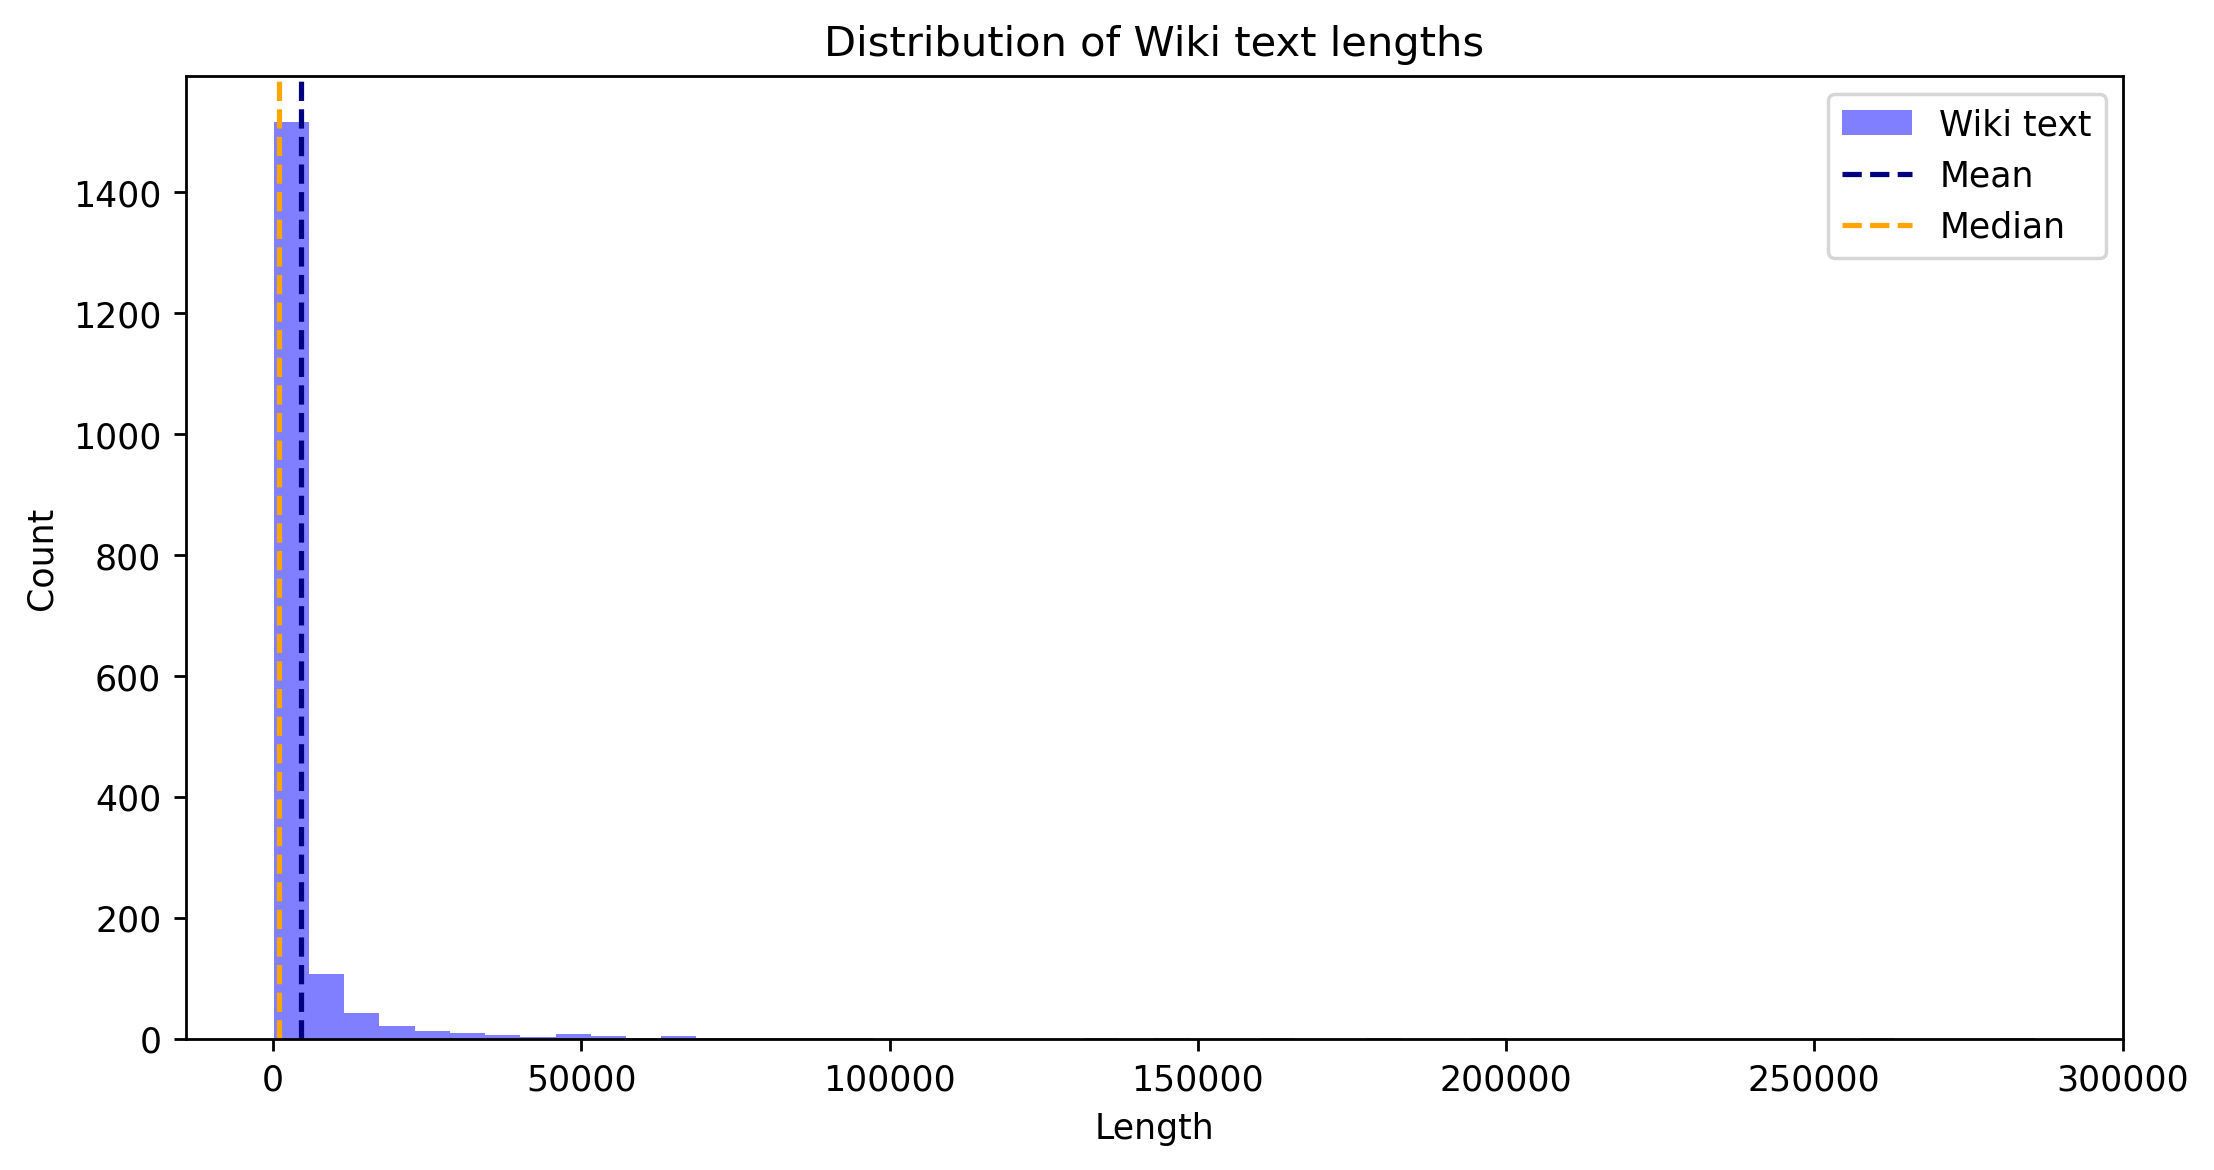

In [44]:
wiki_lengths = [len(text) for text in filtered_data['Wiki text']]


fig, axes = plt.subplots(figsize=(10,5), dpi=250)
axes.hist(wiki_lengths, bins=50, color='blue', alpha=0.5, label='Wiki text')
axes.axvline(sum(wiki_lengths)/len(wiki_lengths), color='navy', linestyle='--', label='Mean')
axes.axvline(sorted(wiki_lengths)[len(wiki_lengths)//2], color='orange', linestyle='--', label='Median')
axes.set_title('Distribution of Wiki text lengths')
axes.set_xlabel('Length')
axes.set_ylabel('Count')
axes.legend()
plt.savefig('Distribution_wiki_text.png', dpi=300)

plt.show()



<a id='tokenize'></a>
## Tokenize

In [8]:
# Function to tokenize text
def tokenize_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token != 'none' and token != 'nan']
    return tokens

# Add column 'tokens' to df
filtered_data['tokens'] = filtered_data['Wiki text'].apply(tokenize_text) 

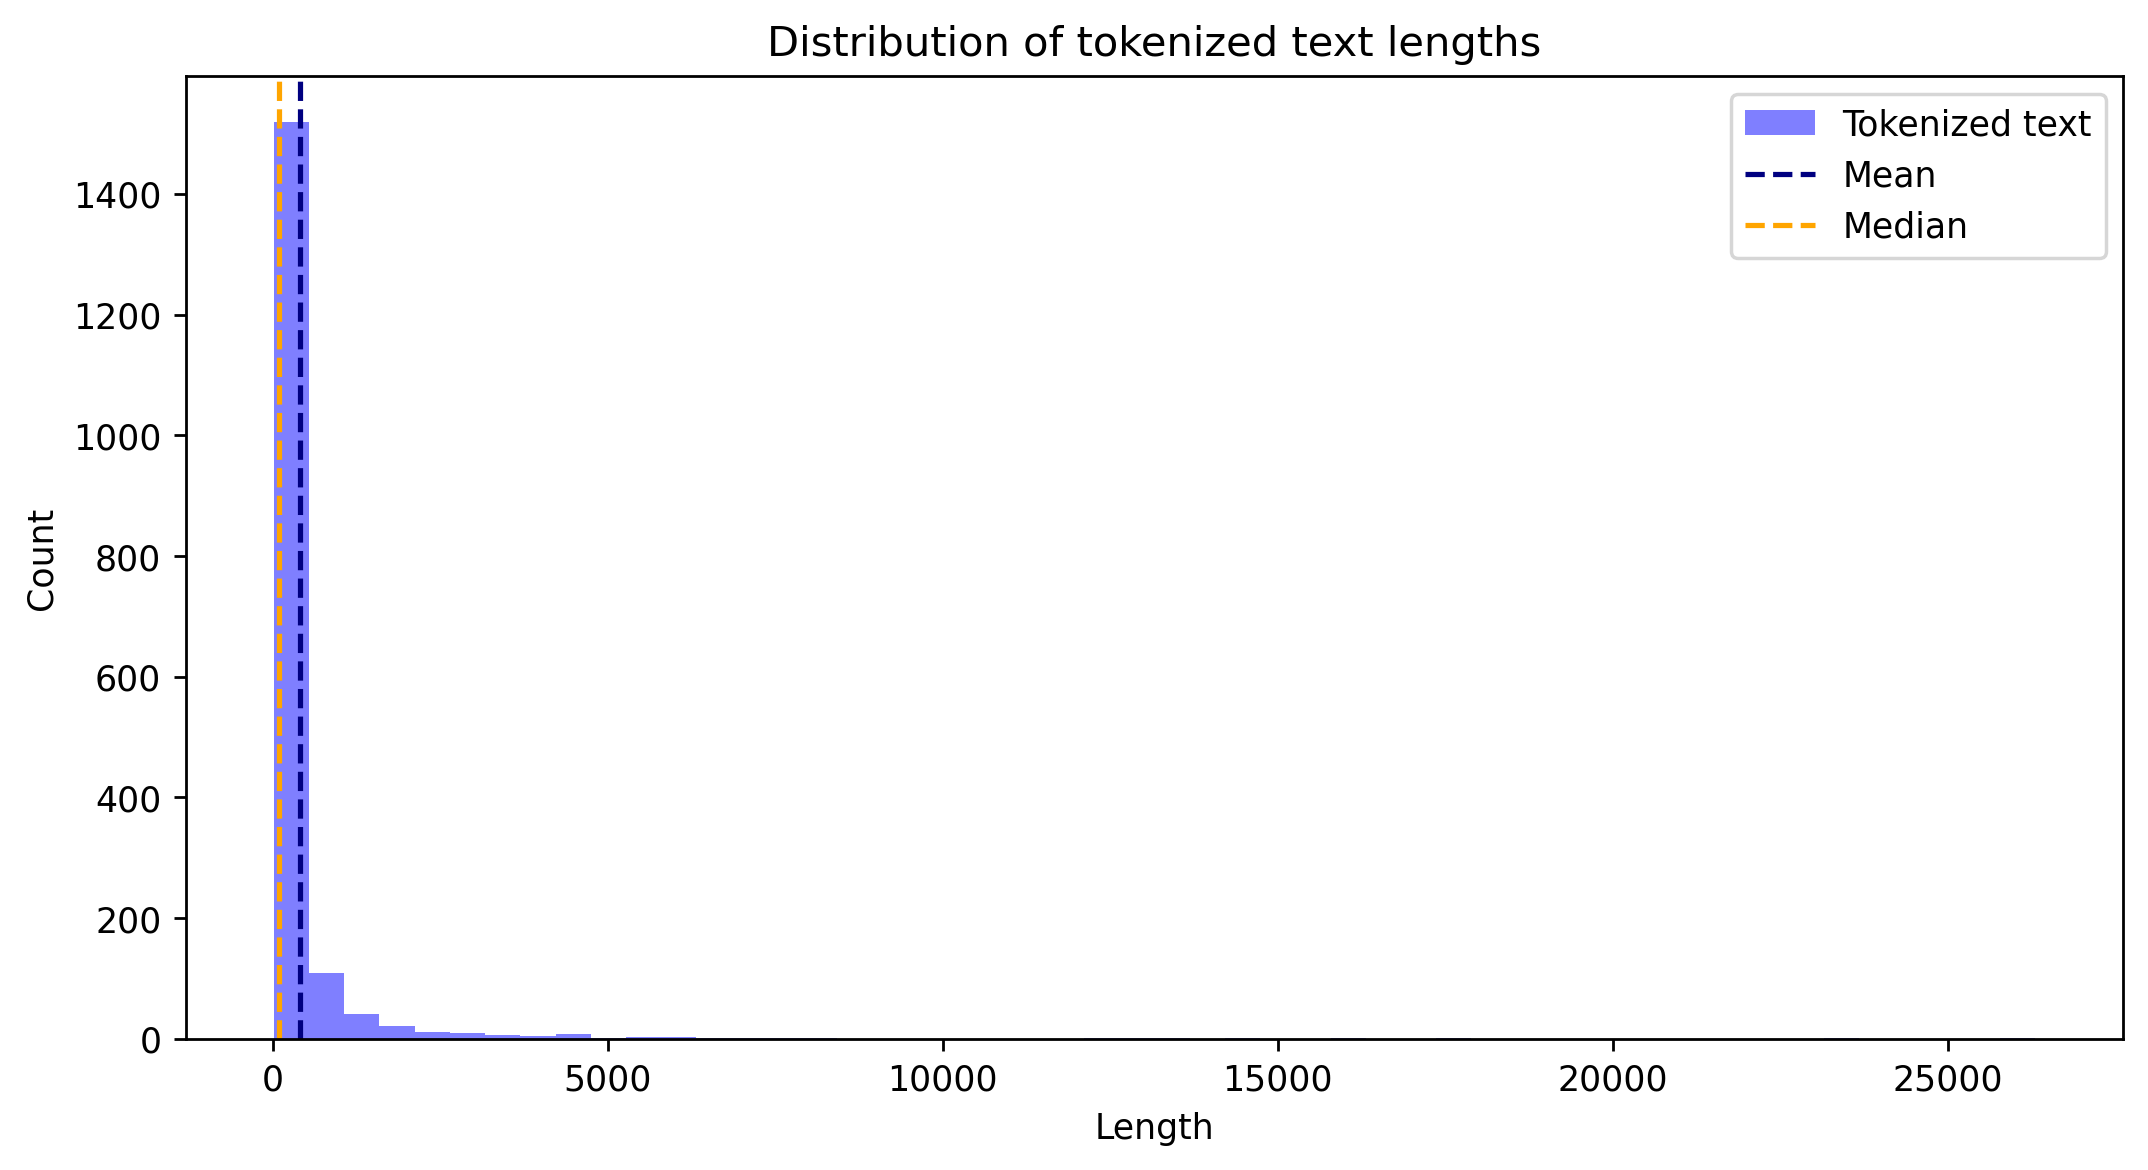

In [43]:
token_lengths = [len(tokens) for tokens in filtered_data['tokens']]


# Plot the distribution of the tokenized text lengths
fig, axes = plt.subplots(figsize=(10,5), dpi=250)
axes.hist(token_lengths, bins=50, color='blue', alpha=0.5, label='Tokenized text')
axes.axvline(sum(token_lengths)/len(token_lengths), color='navy', linestyle='--', label='Mean')
axes.axvline(sorted(token_lengths)[len(token_lengths)//2], color='orange', linestyle='--', label='Median')
axes.set_title('Distribution of tokenized text lengths')
axes.set_xlabel('Length')
axes.set_ylabel('Count')
axes.legend()
plt.savefig('Distribution_wiki_text_tokenized.png', dpi=300)

plt.show()



In [41]:
def compute_difference(row):
    return len(row["Wiki text"]) - len(row["tokens"])

filtered_data["length_difference"] = filtered_data.apply(compute_difference, axis=1)

average_wiki_length = filtered_data["Wiki text"].str.len().mean()
print(f"Average length of 'Wiki text': {average_wiki_length:.2f}")
average_tokens_length = filtered_data["tokens"].str.len().mean()
print(f"Average length of 'tokens': {average_tokens_length:.2f}")
average_difference = filtered_data["length_difference"].mean()
print(f"Average difference: {average_difference:.2f}")

Average length of 'Wiki text': 4486.30
Average length of 'tokens': 405.92
Average difference: 4080.38


We see that tokenizing the text drastically reduced the amount of words in each charecters wikipedia text. This makes sense, since Wikipedia articles often are written in a very formal style and aim to provide comprehensive and neutral information on a particular topic. As a result, they often contain a lot of common and generic words known as stopwords. By tokenizing the text we also remove things such as punctuation, numbers, and special characters, which also plays a part in the reduction.

<a id='house-wordclouds'></a>
## House wordclouds 

In [9]:
house_documents = {}

for house in filtered_data['House'].unique():
    if house is None or house == "None":
        continue
    house_df = filtered_data[filtered_data['House'] == house]
    house_document = ' '.join(house_df['tokens'].explode().tolist())
    house_documents[house] = house_document

# Print the names of the house documents
print("Names of house documents:")
for house in house_documents:
    print(house)
    
# Count the number of house documents
num_houses = len(house_documents)
print("Number of house documents:", num_houses)

Names of house documents:
Unknown
Hufflepuff
Slytherin
Ravenclaw
Gryffindor
Thunderbird
Pukwudgie
Wampus
Number of house documents: 8


In [48]:
### VERY LONG OUTPUT - no need to run cell,
# Just to check specific house document output
selected_house = "Gryffindor" 

if selected_house in house_documents:
    print(f"House: {selected_house}\nDocument: {house_documents[selected_house]}\n")
else:
    print(f"No document found for the house '{selected_house}'.\n")

House: Gryffindor
Document: point albus percival wulfric brian dumbledore biographical information born late august mouldonthewold england great britain died june aged astronomy tower hogwarts castle highlands scotland great britain blood status halfblood likely marital status single nationality english titles prefecthead boyprofessorhead transfiguration formerlyheadmastergrand sorcerersupreme mugwump formerlychief warlock signature physical information species human gender male height weight lbs lbs formerly hair colour silverauburn formerly eye colour blue skin colour fair relationship information family members percival dumbledore father †kendra dumbledore mother †aberforth dumbledore younger brotherariana dumbledore younger sister †aurelius dumbledore nephewhonoria auntmr dumbledore paternal greatgreatgrandfather †dumbledore family romances gellert grindelwald former lover magical characteristics boggart corpse sister ariana wand unknown length wood core formerly elder thestral tai

In [10]:
house_colors = {
    "Gryffindor": "#7F0909",
    "Hufflepuff": "#FFC500",
    "Ravenclaw": "#0A5EA8",
    "Slytherin": "#1A472A"
}

def generate_wordcloud_tf_idf(tfidf_scores):
    for house, tfidf in tfidf_scores.items():
        data = dict(tfidf)
        color = house_colors.get(house, 'white')
        wordcloud = WordCloud(width=800, height=800, background_color=color,
                              min_font_size=10, colormap='viridis')
        wordcloud.generate_from_frequencies(frequencies=data)
        plt.figure(figsize=(3, 3), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(house) #Add house name title to tell them appart even if not apparent
        plt.tight_layout(pad=0)
        plt.show()


Top 10 words and scores for Gryffindor :
harry 0.5861462680076663
ron 0.2347650556979932
hogwarts 0.22301403005913825
hermione 0.22199220174271608
dumbledore 0.1720503427775826
weasley 0.1438223355364202
year 0.14011820788938983
school 0.13564770900504286
potter 0.13168812427890694
voldemort 0.11661615661167997
--------------------------


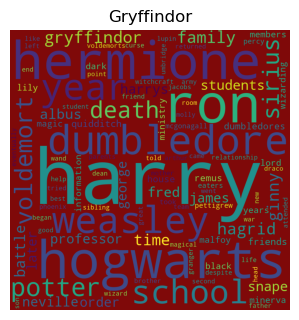

Top 10 words and scores for Slytherin :
harry 0.3269527068515053
voldemort 0.2878410851562119
black 0.23671478228654724
hogwarts 0.23543662471480561
snape 0.2165198926530297
death 0.18967858364645576
draco 0.16743864189815166
family 0.1633485376685785
school 0.15414580315203885
slytherin 0.14980006740811735
--------------------------


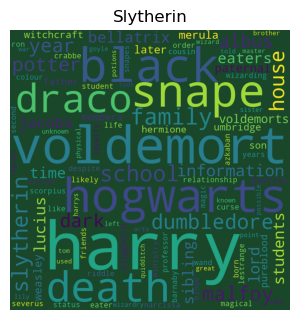

Top 10 words and scores for Hufflepuff :
newt 0.31767164296338185
harry 0.27576602197672295
hogwarts 0.27509012486403495
school 0.21966656162361511
year 0.20141733958103786
hufflepuff 0.16491889549588334
jacobs 0.15883582148169093
penny 0.15613223303093873
tonks 0.1541045416928746
sibling 0.15207685035481047
--------------------------


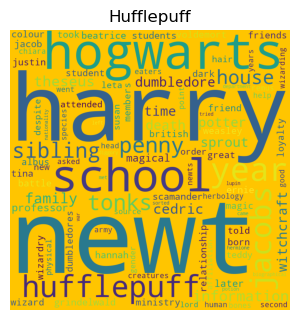

Top 10 words and scores for Ravenclaw :
harry 0.41612785521950924
hogwarts 0.28492216362015854
school 0.26241138319870133
year 0.21031500565190034
luna 0.19680853739902598
ravenclaw 0.17108193120307488
potter 0.14599849016202254
lockhart 0.1414963340777311
professor 0.13763734314833845
students 0.12863303097975556
--------------------------


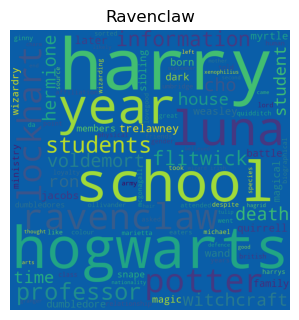

In [95]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', use_idf=True)
selected_houses = ['Gryffindor', 'Slytherin', 'Hufflepuff', 'Ravenclaw']

for house in selected_houses:
    document = house_documents.get(house)
    if document is None:
        continue
    tfidf = vectorizer.fit_transform([document])
    words = vectorizer.get_feature_names()
    scores = tfidf.toarray()[0]
    # Top 100 words
    top100_scores = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:100]
    top10_scores = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:10]
    
    print("Top 10 words and scores for", house, ":")
    for word, score in top10_scores:
        print(word, score)
    print("--------------------------")
    
    # Generate wordcloud for the current house
    generate_wordcloud_tf_idf({house: top100_scores})


<a id='personal-wordclouds'></a>
## Personal wordclouds

In [ ]:
## Normal wordclouds

# Fjern future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

top_10_characters = ['Harry James Potter', 'Tom Marvolo Riddle', 'Albus Percival Wulfric Brian Dumbledore', 'Ronald Bilius Weasley', 'Hermione Jean Granger', 'Sirius Black III', 'Ginevra Molly Potter (née Weasley)', 'Severus Snape', 'Arthur Weasley', 'Draco Lucius Malfoy']
df = filtered_data[filtered_data['Name'].isin(top_10_characters)]
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', use_idf=True)

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
axs = axs.ravel()
# Generate wordclouds for each character
for i, character in enumerate(top_10_characters):
    documents = df[df['Name'] == character]['tokens']
    documents = [' '.join(tokens) for tokens in df[df['Name'] == character]['tokens']]
    tfidf = vectorizer.fit_transform(documents)
    words = vectorizer.get_feature_names()
    scores = tfidf.toarray().mean(axis=0)

    # Sort the words by scores
    words_scores = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:100]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words_scores))
    # plot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(character)

plt.show()

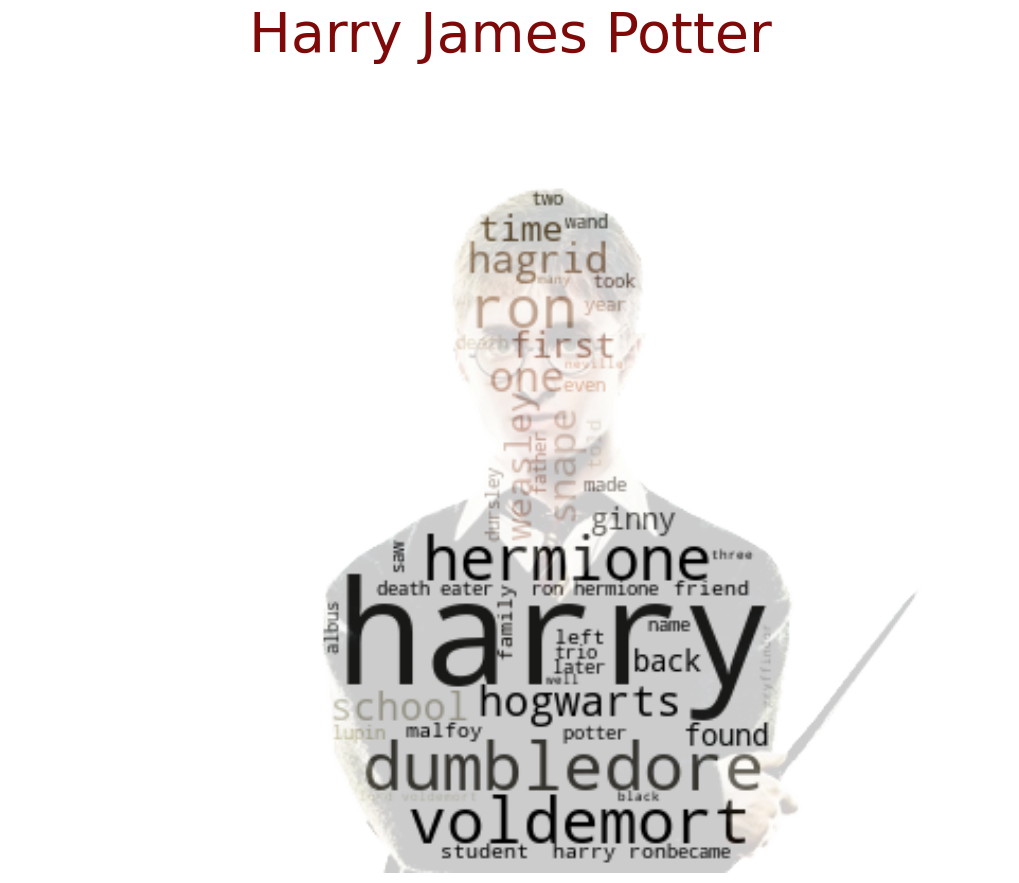

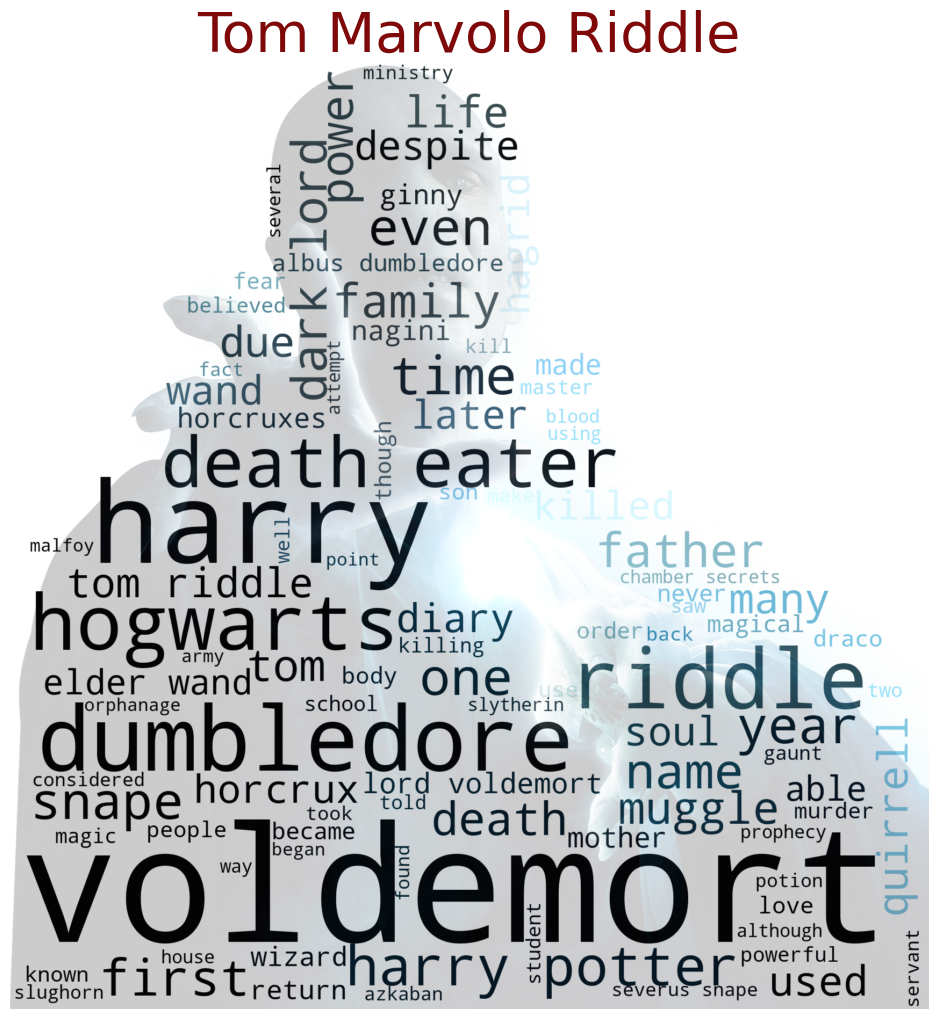

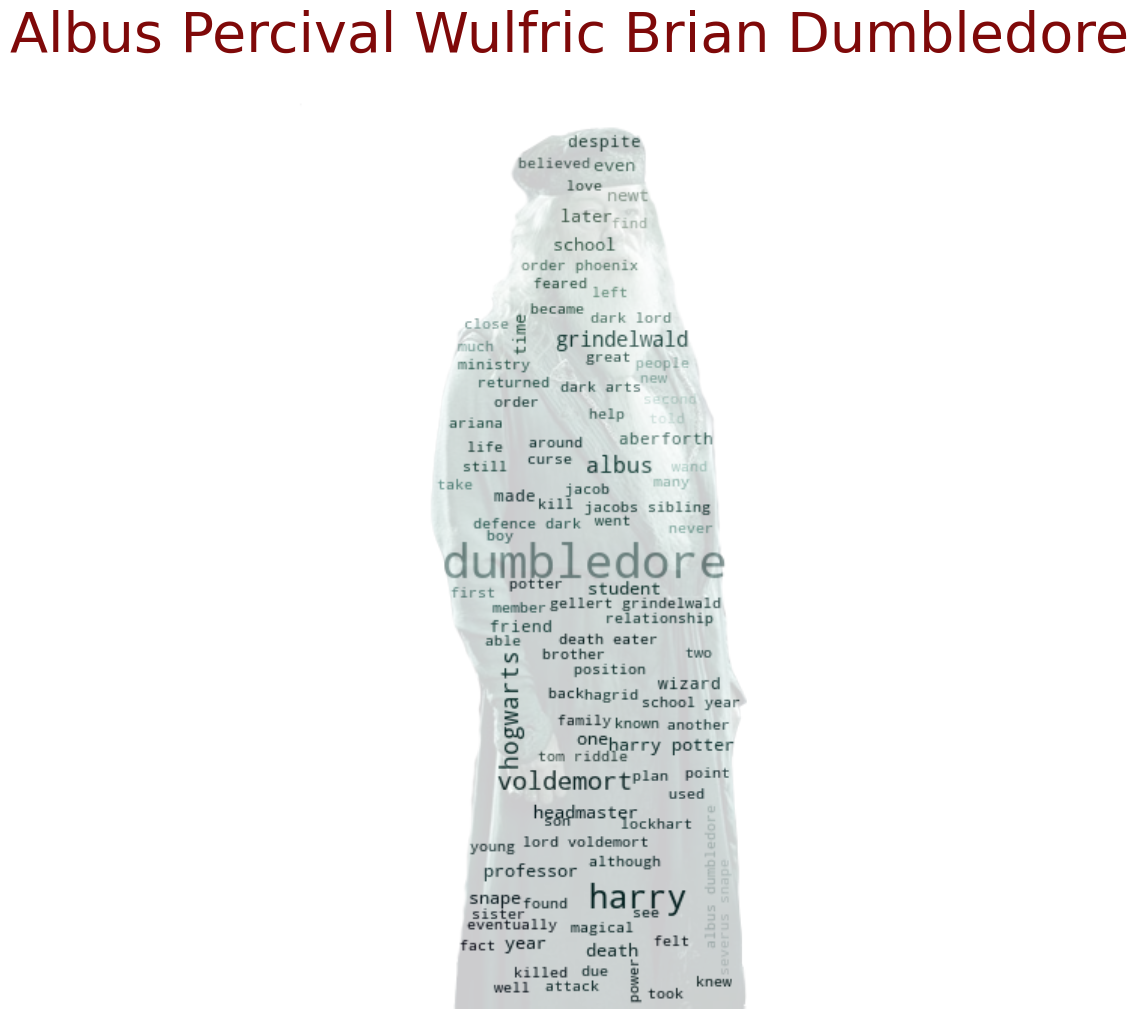

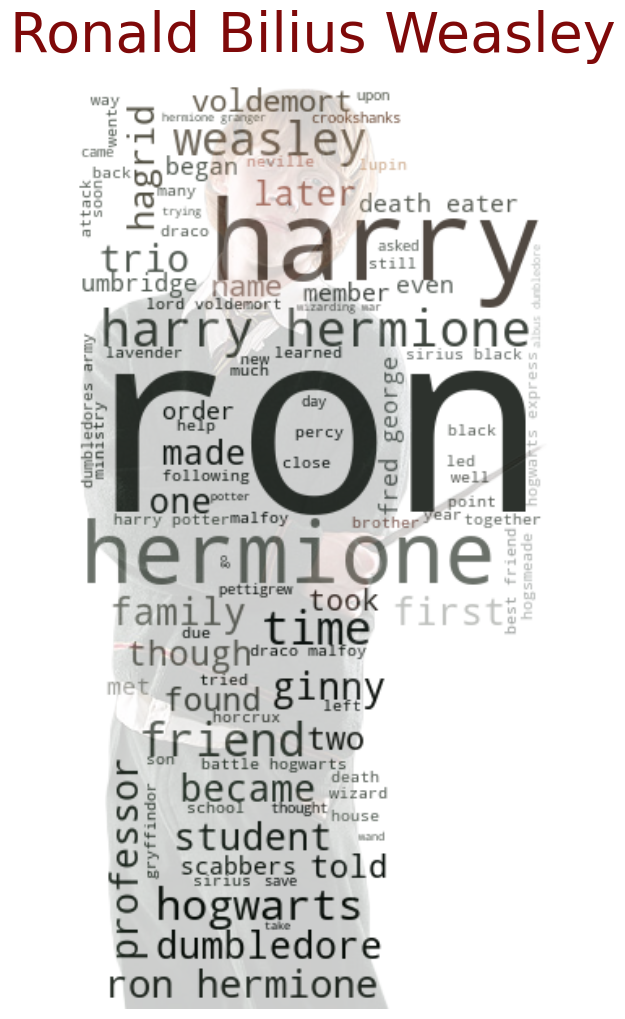

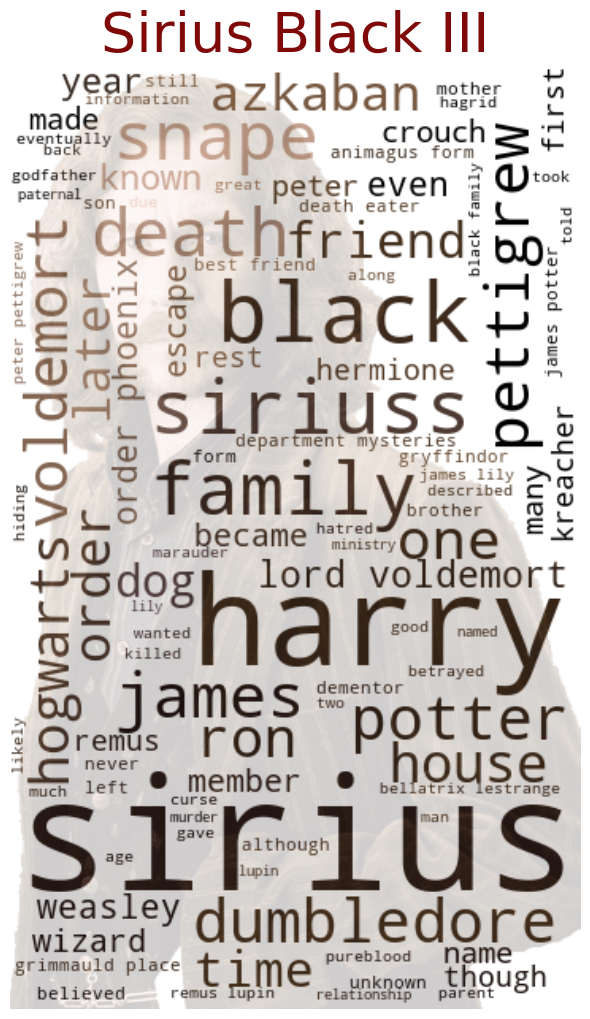

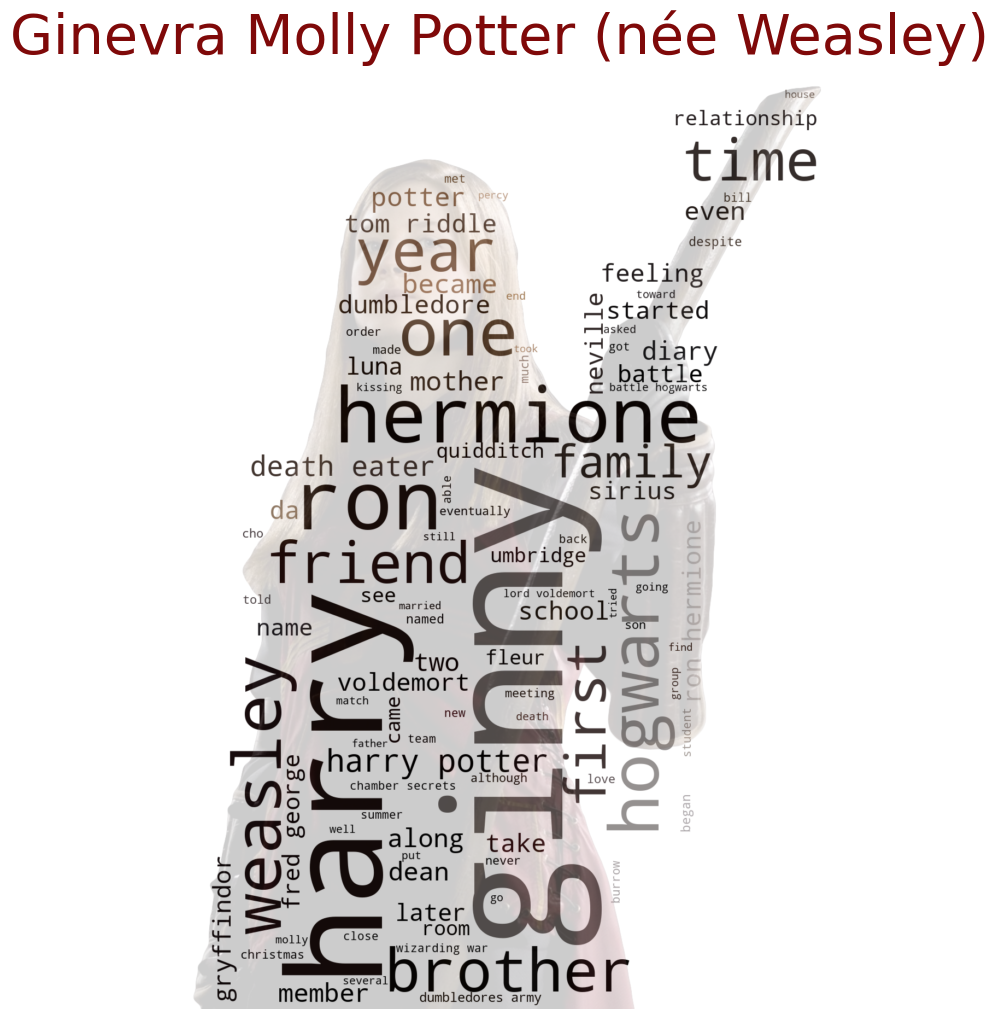

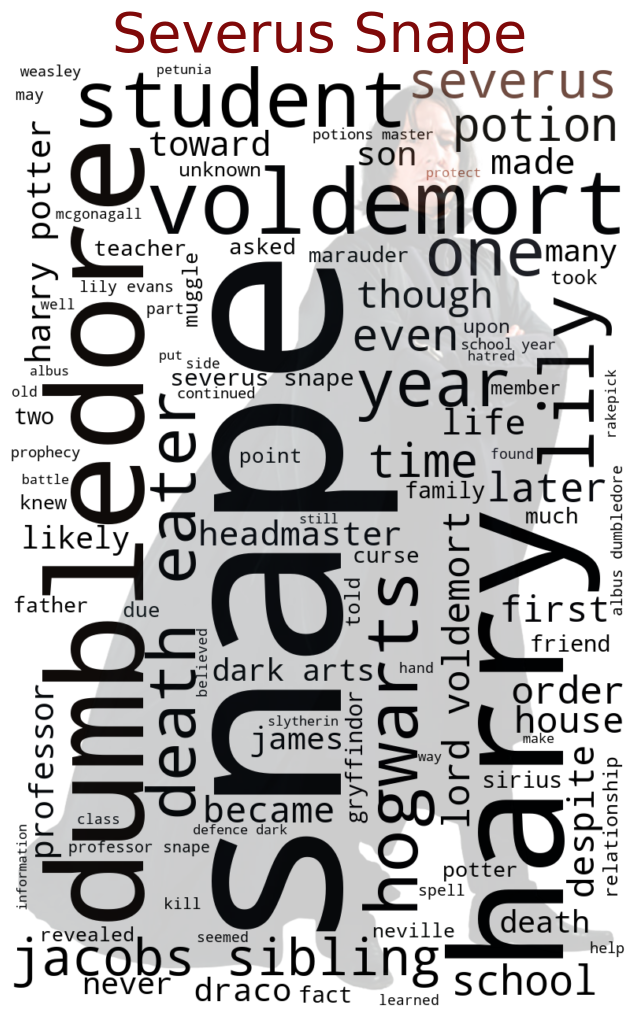

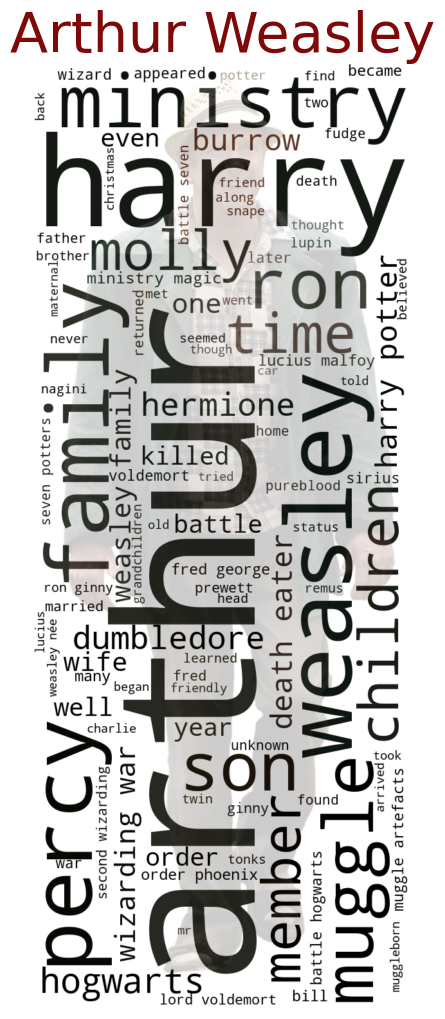

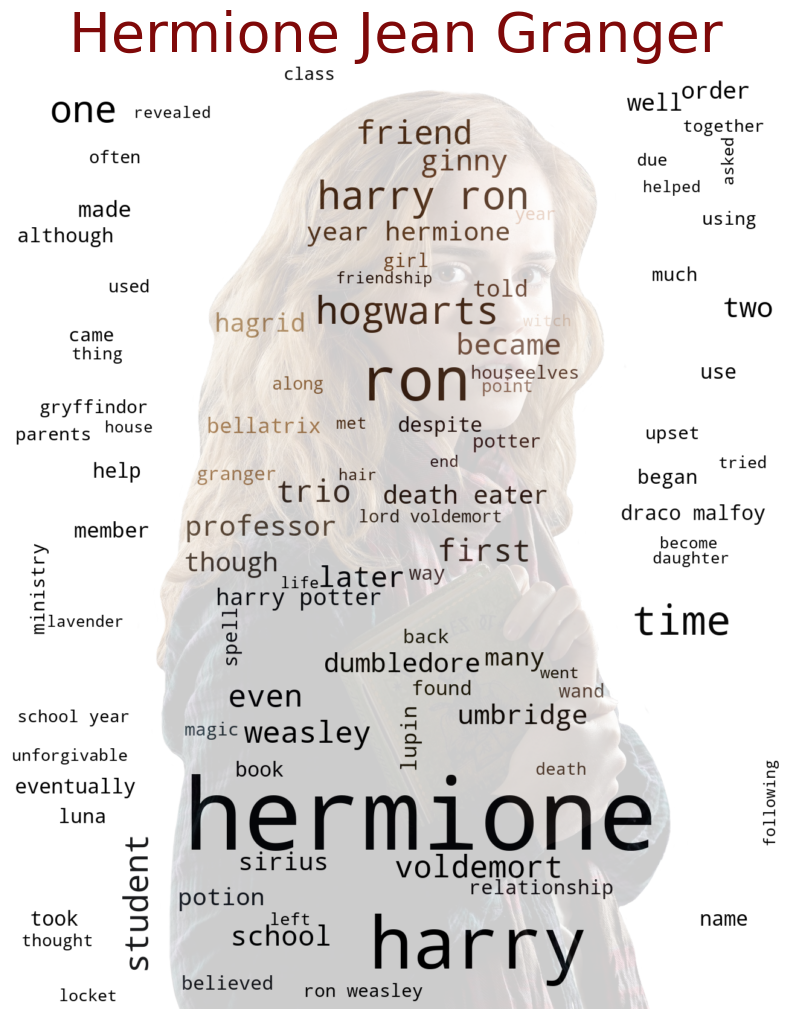

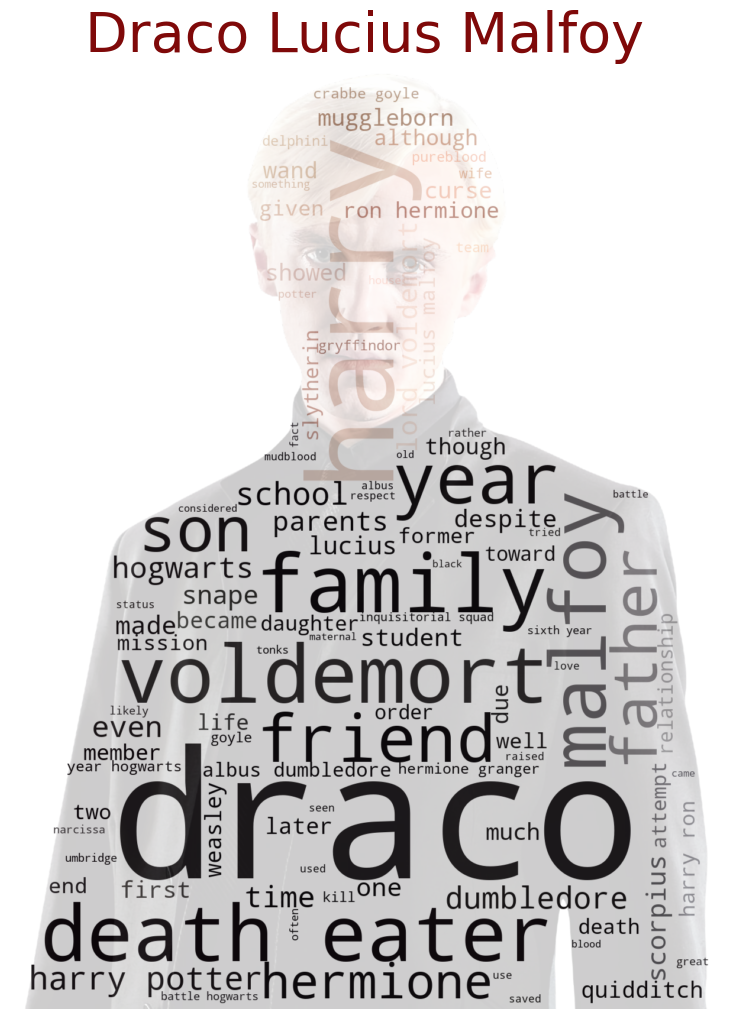

In [19]:
## Special wordclouds


top_10_characters = ['Harry James Potter', 'Tom Marvolo Riddle', 'Albus Percival Wulfric Brian Dumbledore', 'Ronald Bilius Weasley', 'Hermione Jean Granger', 'Sirius Black III', 'Ginevra Molly Potter (née Weasley)', 'Severus Snape', 'Arthur Weasley', 'Draco Lucius Malfoy']
df = filtered_data[filtered_data['Name'].isin(top_10_characters)]

# Load the image paths 
image_paths = {
    "Harry James Potter": "Charecter_png/harry_potter.png",
    "Tom Marvolo Riddle": "Charecter_png/tom_riddle.png",
    "Albus Percival Wulfric Brian Dumbledore": "Charecter_png/Albus.png",
    "Ronald Bilius Weasley": "Charecter_png/ron_weasley.png",
    "Sirius Black III": "Charecter_png/siruis_black.png",
    "Ginevra Molly Potter (née Weasley)": "Charecter_png/ginny.png",
    "Severus Snape": "Charecter_png/Snape.png",
    "Arthur Weasley": "Charecter_png/Arthur.png",
    "Hermione Jean Granger": "Charecter_png/hermione_granger.png",
    "Draco Lucius Malfoy": "Charecter_png/Draco_Malfoy.png",
}

for character in image_paths:
    # Load image 
    img = Image.open(image_paths[character])
    
    documents = df[df['Name'] == character]['tokens']

    text = ' '.join(documents.apply(lambda x: ' '.join(x)))
    mask = np.array(img)
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white", stopwords=stopwords, mask=mask, width=3000, height=3000, 
                   max_words=100, max_font_size=300, min_font_size=5)
    wc.generate(text)
    image_colors = ImageColorGenerator(mask)
    
    # Figure
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
    ax.imshow(mask, cmap=plt.cm.gray, alpha=0.2, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(character, fontsize=40, color='#7F0909')

    # plt.tight_layout(pad=0)
    # plt.savefig(f"static/images/{character}.png", format='png', dpi=300)
    # plt.show()
    
